In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import m2cgen as m2c

In [2]:
# 1. Load data
df = pd.read_csv("data_sensor.csv")

In [3]:
# 2. Handle missing values (isi dengan mean)
df.fillna(df.mean(numeric_only=True), inplace=True)

In [4]:
# 3. Pisahkan fitur dan label
X = df[['BPM', 'BodyTemperature', 'AmbientTemperature']]
y = df['Fatigue']

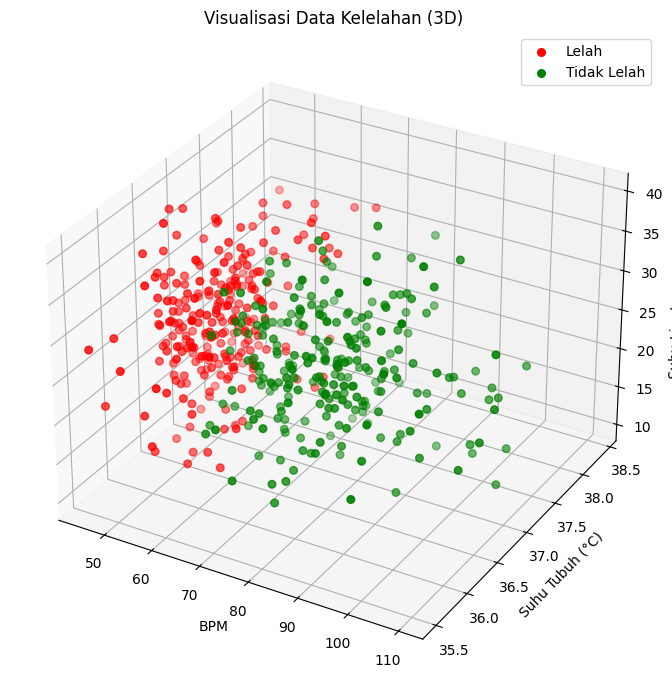

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Pisahkan berdasarkan kelas
X_fatigue = X[y == 1]
X_not_fatigue = X[y == 0]

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Titik-titik LELAH (1) → merah
ax.scatter(X_fatigue['BPM'], X_fatigue['BodyTemperature'], X_fatigue['AmbientTemperature'],
           c='red', label='Lelah', s=30, marker='o')

# Titik-titik TIDAK LELAH (0) → hijau
ax.scatter(X_not_fatigue['BPM'], X_not_fatigue['BodyTemperature'], X_not_fatigue['AmbientTemperature'],
           c='green', label='Tidak Lelah', s=30, marker='o')

# Label dan tampilan
ax.set_xlabel('BPM')
ax.set_ylabel('Suhu Tubuh (°C)')
ax.set_zlabel('Suhu Lingkungan (°C)')
ax.set_title('Visualisasi Data Kelelahan (3D)')
ax.legend()

plt.tight_layout()
plt.show()


In [6]:
# 4. Normalisasi (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
# 6. Train SVM (linear agar bisa dikonversi ke TinyML)
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [9]:
# 7. Evaluasi
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        46
           1       0.94      0.94      0.94        54

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

Confusion Matrix:
[[43  3]
 [ 3 51]]


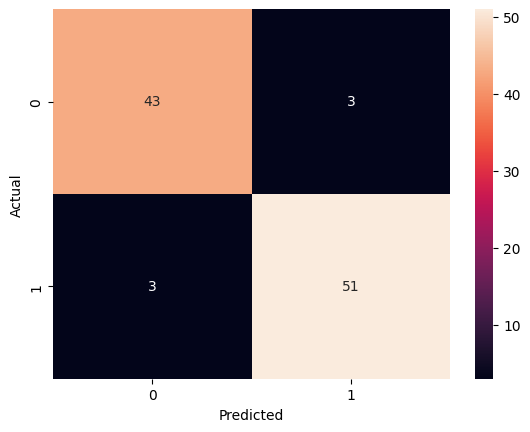

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [10]:
# 8. Konversi model ke kode C untuk ESP32 (TinyML)
c_code = m2c.export_to_c(model)

In [11]:
# Simpan sebagai file .c
with open("svm_model_fatigue.c", "w") as f:
    f.write(c_code)

In [12]:
# Simpan juga scaler (opsional jika digunakan di sisi ESP)
import joblib
joblib.dump(scaler, "scaler_fatigue.save")

['scaler_fatigue.save']